# HW1 313511068 練鈞揚

## Part 2 Transformer

In [1]:
import pandas as pd
import numpy as np
import torch
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
import re

from torch import nn
import torch.nn.functional as F
import math

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [2]:
# 1. Read and Parse Data
train_data = pd.read_csv('train.csv')
val_data = pd.read_csv('val.csv')
test_data = pd.read_csv('test.csv')

X_train = train_data['text'].values
y_train = train_data['label'].values

X_val = val_data['text'].values
y_val = val_data['label'].values

X_test = test_data['text'].values
y_test = test_data['label'].values

In [3]:
# 2. Tokenize Data
def tokenizer(text):
    text = re.sub(r'[^\w\s]', '', text.lower())
    return text.split()

def build_vocab(sentences):
    counter = Counter()
    for sentence in sentences:
        tokens = tokenizer(sentence)
        counter.update(tokens)
    vocab = {word: idx+2 for idx, (word, _) in enumerate(counter.items())} 
    vocab["<pad>"] = 0
    vocab["<unk>"] = 1
    return vocab

vocab = build_vocab(X_train)

In [4]:
# 3. Preprocess Data
def text_pipeline(text, vocab):
    tokens = tokenizer(text)
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]

label_vocab = {label: idx for idx, label in enumerate(set(y_train))}

def label_pipeline(label):
    label_index = label_vocab[label]
    one_hot = torch.zeros(4, dtype=torch.float)
    one_hot[label_index] = 1.0
    
    return one_hot

In [5]:
# 4. Prepare Data
X_train_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_train]
X_val_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_val]
X_test_seq = [torch.tensor(text_pipeline(text, vocab)) for text in X_test]

X_train_pad = pad_sequence(X_train_seq, batch_first=True, padding_value=vocab["<pad>"])
X_val_pad = pad_sequence(X_val_seq, batch_first=True, padding_value=vocab["<pad>"])
X_test_pad = pad_sequence(X_test_seq, batch_first=True, padding_value=vocab["<pad>"])

max_len = 32
X_train_pad = X_train_pad[:, :max_len]
X_val_pad = X_val_pad[:, :max_len]
X_test_pad = X_test_pad[:, :max_len]

X_train_pad = torch.cat([
    X_train_pad, 
    torch.full((X_train_pad.size(0), max_len - X_train_pad.size(1)), vocab["<pad>"])
], dim=1)

X_val_pad = torch.cat([
    X_val_pad, 
    torch.full((X_val_pad.size(0), max_len - X_val_pad.size(1)), vocab["<pad>"])
], dim=1)

X_test_pad = torch.cat([
    X_test_pad, 
    torch.full((X_test_pad.size(0), max_len - X_test_pad.size(1)), vocab["<pad>"])
], dim=1)

y_train_tensor = torch.stack([label_pipeline(label) for label in y_train])
y_val_tensor = torch.stack([label_pipeline(label) for label in y_val])
y_test_tensor = torch.stack([label_pipeline(label) for label in y_test])



In [6]:
# 5. Create DataLoader
train_dataset = TensorDataset(X_train_pad, y_train_tensor)
val_dataset = TensorDataset(X_val_pad, y_val_tensor)
test_dataset = TensorDataset(X_test_pad, y_test_tensor)

batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [7]:
# 6. PositionalEncoding
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [8]:
# 7. Multi-head Attention
class MyMultiHeadAttention(nn.Module):
    # Multi-head Attention Layer. Please study Transformer paper https://arxiv.org/pdf/1706.03762
    
    def __init__(self,d_model : int,nhead:int ,dropout: float):
        super().__init__()  
        assert d_model % nhead == 0, "d_model must be divisible by num_heads"
        self.d_model = d_model
        self.nhead = nhead
        self.depth = d_model // nhead
        
        self.q_linear =  nn.Linear(d_model,d_model)
        self.k_linear =  nn.Linear(d_model,d_model)
        self.v_linear =  nn.Linear(d_model,d_model)
        self.o_linear =  nn.Linear(d_model,d_model)
        return 
    
    def split_heads(self, x, batch_size):
        """
        Split the last dimension into (num_heads, depth).
        Transpose the result to get the shape (batch_size, num_heads, seq_len, depth).
        """
        x = x.reshape(batch_size, -1, self.nhead, self.depth)
        return x.transpose(1, 2)
    
    def forward(self, q:torch.Tensor,k:torch.Tensor,v:torch.Tensor):
        
        batch_size = q.size(0)
        # 生成 Q、K、V
        q = self.q_linear(q)
        k = self.k_linear(k)
        v = self.v_linear(v)

        # 分割为多个头 (batch_size, num_heads, seq_length, head_dim)
        Q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len, depth)
        K = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len, depth)
        V = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len, depth)

        # Scaled dot-product attention
        # attention_output, _ = self.scaled_dot_product_attention(Q, K, V)
        attention_output = F.scaled_dot_product_attention(Q, K, V)
        
        # Concatenate heads
        attention_output = attention_output.transpose(1, 2).contiguous()  # (batch_size, seq_len, num_heads, depth)
        concat_attention = attention_output.view(batch_size, -1, self.d_model)  # (batch_size, seq_len, d_model)

        # Apply final linear transformation
        output = self.o_linear(concat_attention)  # (batch_size, seq_len, d_model)
        return output
        

In [9]:
# 8. TransformerEncoderLayer
class MyTransformerEncoderLayer(nn.Module):    
    # Transformer Encoder Layer. Please study Transformer paper https://arxiv.org/pdf/1706.03762
    def __init__(self,d_model : int, nhead:int, dim_feedforward:int, dropout:float):
        super().__init__()
        
        self.self_attn = MyMultiHeadAttention(d_model, nhead,dropout)
        
        self.feedforward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(), # max(0 , or linear)
            nn.Linear(dim_feedforward, d_model)
        )
        
        # 层归一化和dropout
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
        return 
    
    def forward(self, x):
        # 自注意力机制
        attn_output = self.self_attn(x,x,x)
        
        # 残差连接和归一化
        x = x + self.dropout(attn_output)
        x = self.norm1(x)
        
        # 前馈神经网络
        ff_output = self.feedforward(x)
        
        # 残差连接和归一化
        x = x + self.dropout(ff_output)
        x = self.norm2(x)
        
        return x 

In [10]:
# 9. TransformerClassifier
class TransformerClassifier(nn.Module):
    def __init__(
        self,
        vocab_size,
        embedding_dim,
        output_dim,
        pad_idx,
        nhead=8,
        num_layers=6,
    ):
        super(TransformerClassifier, self).__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_idx)
        self.pos_encoder = PositionalEncoding(
            d_model=embedding_dim,
            dropout=0.2,
            max_len=embedding_dim,  
        )
        
        self.encoder_layers = nn.ModuleList(
            [MyTransformerEncoderLayer(d_model=embedding_dim, nhead=nhead, dim_feedforward=64, dropout=0.2) 
             for _ in range(num_layers)]
        )

        self.linear_layer = nn.Linear(embedding_dim, 32)
        self.classifier = nn.Linear(32, output_dim)
        self.d_model = embedding_dim

    def forward(self, x):
        x = self.embedding(x) * torch.sqrt(torch.tensor(self.d_model, dtype=torch.float))  
        x = self.pos_encoder(x)
        
        for layer in self.encoder_layers:
            x = layer(x)

        x = x.mean(dim=1)
        
        x = self.linear_layer(x)
        x = torch.tanh(x)
        
        x = self.classifier(x)
        
        return x  

In [11]:
# 10. Define Hyperparameters
vocab_size = len(vocab)
embedding_dim = 128
output_dim = len(label_vocab)
pad_idx = vocab["<pad>"]

In [12]:
# 11. Create Model
model_1 = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=1,  
    num_layers=6 
)

model_4 = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=4,  
    num_layers=6 
)


model_8 = TransformerClassifier(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    output_dim=output_dim,
    pad_idx=pad_idx,
    nhead=8,  
    num_layers=6 
)



In [13]:
print(model_1)

TransformerClassifier(
  (embedding): Embedding(9547, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x MyTransformerEncoderLayer(
      (self_attn): MyMultiHeadAttention(
        (q_linear): Linear(in_features=128, out_features=128, bias=True)
        (k_linear): Linear(in_features=128, out_features=128, bias=True)
        (v_linear): Linear(in_features=128, out_features=128, bias=True)
        (o_linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (feedforward): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (linear_layer): Linear(in_features=12

In [14]:
print(model_4)

TransformerClassifier(
  (embedding): Embedding(9547, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x MyTransformerEncoderLayer(
      (self_attn): MyMultiHeadAttention(
        (q_linear): Linear(in_features=128, out_features=128, bias=True)
        (k_linear): Linear(in_features=128, out_features=128, bias=True)
        (v_linear): Linear(in_features=128, out_features=128, bias=True)
        (o_linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (feedforward): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (linear_layer): Linear(in_features=12

In [15]:
print(model_8)

TransformerClassifier(
  (embedding): Embedding(9547, 128, padding_idx=0)
  (pos_encoder): PositionalEncoding(
    (dropout): Dropout(p=0.2, inplace=False)
  )
  (encoder_layers): ModuleList(
    (0-5): 6 x MyTransformerEncoderLayer(
      (self_attn): MyMultiHeadAttention(
        (q_linear): Linear(in_features=128, out_features=128, bias=True)
        (k_linear): Linear(in_features=128, out_features=128, bias=True)
        (v_linear): Linear(in_features=128, out_features=128, bias=True)
        (o_linear): Linear(in_features=128, out_features=128, bias=True)
      )
      (feedforward): Sequential(
        (0): Linear(in_features=128, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=128, bias=True)
      )
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.2, inplace=False)
    )
  )
  (linear_layer): Linear(in_features=12

In [16]:
# 12. Define Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_1 = optim.AdamW(model_1.parameters(), lr=0.001)
optimizer_4 = optim.AdamW(model_4.parameters(), lr=0.001)
optimizer_8 = optim.AdamW(model_8.parameters(), lr=0.001)

In [17]:
# 13. Define Training and Evaluation Functions
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs):
    results = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    for epoch in range(epochs):
        model.train()

        batch_loss = []
        batch_acc = []
        
        for batch in train_loader:
            X_batch, y_batch = batch
            
            optimizer.zero_grad()
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            output = model(X_batch)

            loss = criterion(output, y_batch)
            loss.backward()
            optimizer.step()
            batch_loss.append(loss.item())

            _, predicted = torch.max(output, 1)
            y_indices = y_batch.argmax(dim=1)  
            correct = (predicted == y_indices).sum().item()
            batch_acc.append(correct / y_batch.size(0))
        
        results['train_loss'].append(np.mean(batch_loss))
        results['train_acc'].append(np.mean(batch_acc))

        model.eval()
        total_correct = 0  
        total_samples = 0  
        val_batch_loss = []  
        
        with torch.no_grad():
            for X_val_batch, y_val_batch in val_loader:
                X_val_batch, y_val_batch = X_val_batch.to(device), y_val_batch.to(device)
                val_output = model(X_val_batch)
                val_loss = criterion(val_output, y_val_batch)
                val_batch_loss.append(val_loss.item())
                
                _, predicted = torch.max(val_output, 1)
                y_val_indices = y_val_batch.argmax(dim=1)
                total_correct += (predicted == y_val_indices).sum().item()
                total_samples += y_val_batch.size(0)

        results['val_loss'].append(np.mean(val_batch_loss))
        results['val_acc'].append(total_correct / total_samples)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {results['train_loss'][-1]:.4f}, "
              f"Train Acc: {results['train_acc'][-1]:.4f}, Val Loss: {results['val_loss'][-1]:.4f}, "
              f"Val Acc: {results['val_acc'][-1]:.4f}")
        
    return results

In [18]:
# 14. Train Model
history_1 = train_model(model_1, train_loader, val_loader, criterion, optimizer_1, epochs=100)

Epoch 1/100, Train Loss: 1.3803, Train Acc: 0.2938, Val Loss: 1.3711, Val Acc: 0.3266
Epoch 2/100, Train Loss: 1.3169, Train Acc: 0.3593, Val Loss: 1.3345, Val Acc: 0.3427
Epoch 3/100, Train Loss: 1.2857, Train Acc: 0.3781, Val Loss: 1.2934, Val Acc: 0.3669
Epoch 4/100, Train Loss: 1.2393, Train Acc: 0.4375, Val Loss: 1.2505, Val Acc: 0.4677
Epoch 5/100, Train Loss: 1.1748, Train Acc: 0.4823, Val Loss: 1.3033, Val Acc: 0.4153
Epoch 6/100, Train Loss: 1.1305, Train Acc: 0.5143, Val Loss: 1.2232, Val Acc: 0.4798
Epoch 7/100, Train Loss: 1.0556, Train Acc: 0.5597, Val Loss: 1.2051, Val Acc: 0.4919
Epoch 8/100, Train Loss: 1.0192, Train Acc: 0.5780, Val Loss: 1.1656, Val Acc: 0.4960
Epoch 9/100, Train Loss: 0.9521, Train Acc: 0.6177, Val Loss: 1.1135, Val Acc: 0.5403
Epoch 10/100, Train Loss: 0.8940, Train Acc: 0.6415, Val Loss: 1.0365, Val Acc: 0.5726
Epoch 11/100, Train Loss: 0.8573, Train Acc: 0.6658, Val Loss: 1.1466, Val Acc: 0.5524
Epoch 12/100, Train Loss: 0.8190, Train Acc: 0.6858,

In [19]:
# 14. Train Model
history_4 = train_model(model_4, train_loader, val_loader, criterion, optimizer_4, epochs=100)

Epoch 1/100, Train Loss: 1.3662, Train Acc: 0.3157, Val Loss: 1.4030, Val Acc: 0.3306
Epoch 2/100, Train Loss: 1.2480, Train Acc: 0.4299, Val Loss: 1.2951, Val Acc: 0.4032
Epoch 3/100, Train Loss: 1.1301, Train Acc: 0.5194, Val Loss: 1.1092, Val Acc: 0.5484
Epoch 4/100, Train Loss: 1.0607, Train Acc: 0.5597, Val Loss: 1.1006, Val Acc: 0.5323
Epoch 5/100, Train Loss: 0.9774, Train Acc: 0.6115, Val Loss: 0.9896, Val Acc: 0.6048
Epoch 6/100, Train Loss: 0.8630, Train Acc: 0.6708, Val Loss: 0.9835, Val Acc: 0.6290
Epoch 7/100, Train Loss: 0.8064, Train Acc: 0.6971, Val Loss: 0.9901, Val Acc: 0.6129
Epoch 8/100, Train Loss: 0.7227, Train Acc: 0.7407, Val Loss: 0.9285, Val Acc: 0.6613
Epoch 9/100, Train Loss: 0.6703, Train Acc: 0.7559, Val Loss: 1.0167, Val Acc: 0.6290
Epoch 10/100, Train Loss: 0.6461, Train Acc: 0.7616, Val Loss: 0.9484, Val Acc: 0.6573
Epoch 11/100, Train Loss: 0.5666, Train Acc: 0.7992, Val Loss: 0.8683, Val Acc: 0.6815
Epoch 12/100, Train Loss: 0.5419, Train Acc: 0.8051,

In [20]:
history_8 = train_model(model_8, train_loader, val_loader, criterion, optimizer_8, epochs=100)


Epoch 1/100, Train Loss: 1.3710, Train Acc: 0.3145, Val Loss: 1.3092, Val Acc: 0.4194
Epoch 2/100, Train Loss: 1.2423, Train Acc: 0.4483, Val Loss: 1.1748, Val Acc: 0.5323
Epoch 3/100, Train Loss: 1.0799, Train Acc: 0.5602, Val Loss: 1.0916, Val Acc: 0.5524
Epoch 4/100, Train Loss: 0.9478, Train Acc: 0.6305, Val Loss: 1.0724, Val Acc: 0.5887
Epoch 5/100, Train Loss: 0.8309, Train Acc: 0.6883, Val Loss: 0.9595, Val Acc: 0.6653
Epoch 6/100, Train Loss: 0.7415, Train Acc: 0.7287, Val Loss: 0.8967, Val Acc: 0.6895
Epoch 7/100, Train Loss: 0.6951, Train Acc: 0.7487, Val Loss: 0.9613, Val Acc: 0.6694
Epoch 8/100, Train Loss: 0.6210, Train Acc: 0.7769, Val Loss: 0.9118, Val Acc: 0.6734
Epoch 9/100, Train Loss: 0.5554, Train Acc: 0.8033, Val Loss: 0.9178, Val Acc: 0.6613
Epoch 10/100, Train Loss: 0.5138, Train Acc: 0.8205, Val Loss: 0.9478, Val Acc: 0.6895
Epoch 11/100, Train Loss: 0.4835, Train Acc: 0.8267, Val Loss: 0.9000, Val Acc: 0.6895
Epoch 12/100, Train Loss: 0.4476, Train Acc: 0.8441,

In [21]:
# 15. Plot result
import matplotlib.pyplot as plt

def history_plot(history:dict):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'b-', label='Training Accuracy')
    plt.plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

## 1 Head

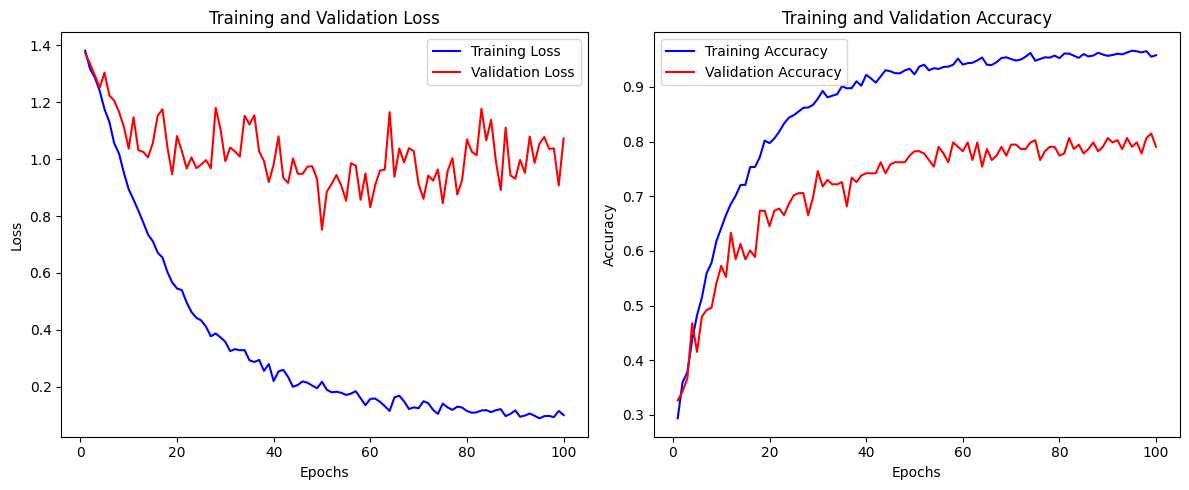

In [22]:
history_plot(history_1)

## 4 Head

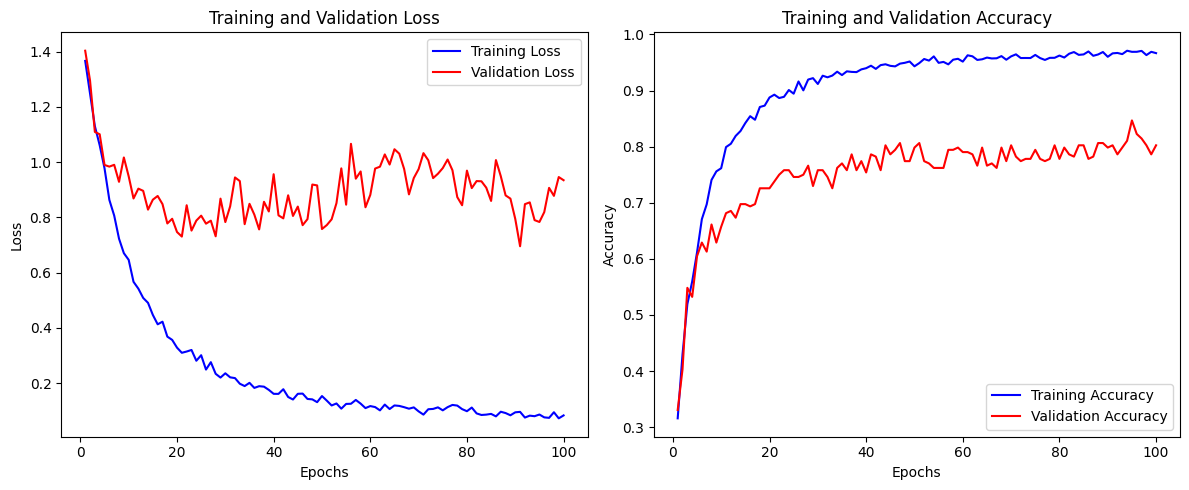

In [23]:
history_plot(history_4)

## 8 Head

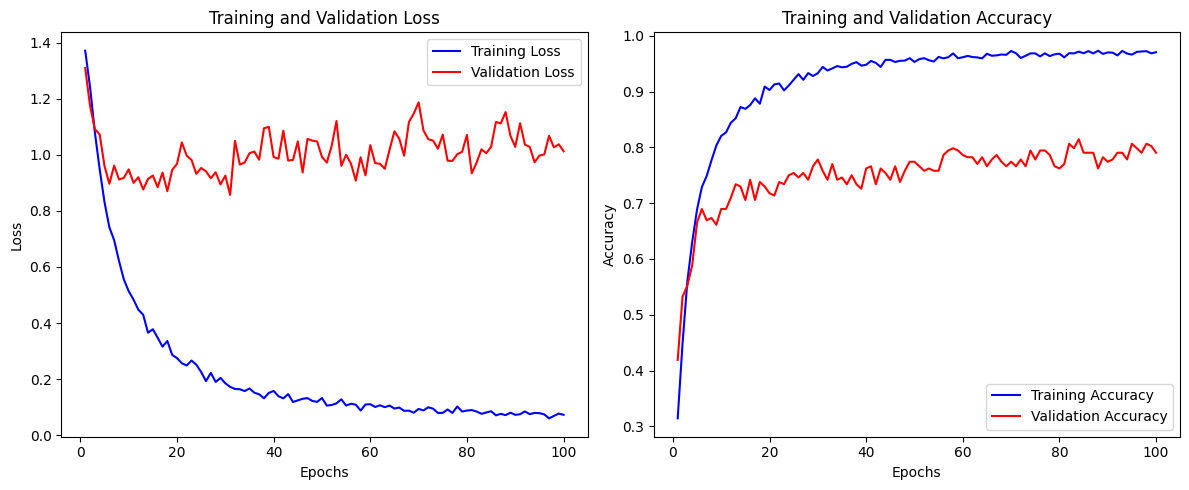

In [24]:
history_plot(history_8)

In [25]:
# 16. Evaluate Model

def evaluate_model(model, test_loader):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    model.eval()
    total_correct = 0
    total_samples = 0
    test_batch_loss = []

    with torch.no_grad():
        for X_test_batch, y_test_batch in test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            test_output = model(X_test_batch)
            test_loss = criterion(test_output, y_test_batch)
            test_batch_loss.append(test_loss.item())

            _, predicted = torch.max(test_output, 1)
            y_test_indices = y_test_batch.argmax(dim=1)
            total_correct += (predicted == y_test_indices).sum().item()
            total_samples += y_test_batch.size(0)

    test_loss = np.mean(test_batch_loss)
    test_acc = total_correct / total_samples
    return test_loss, test_acc



In [26]:
test_loss, test_acc = evaluate_model(model_1, test_loader)
print(f"(1 head)Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

(1 head)Test Loss: 0.9657, Test Acc: 0.7780


In [27]:
test_loss, test_acc = evaluate_model(model_4, test_loader)
print(f"(4 head)Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

(4 head)Test Loss: 0.9311, Test Acc: 0.7960


In [28]:
test_loss, test_acc = evaluate_model(model_8, test_loader)
print(f"(8 head)Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

(8 head)Test Loss: 1.1149, Test Acc: 0.7828


## Transformer Model Performance Report

### Impact of Head Count on Transformer Performance

The Transformer model's prediction results vary across different numbers of attention heads. In our experiment, a configuration with 4 heads yielded better performance than configurations with either 1 or 8 heads. This outcome suggests that the 4-head model size is well-suited to the training and testing data, likely achieving an optimal balance of model capacity and complexity. Consequently, this configuration minimizes loss while delivering higher accuracy compared to the 1-head and 8-head Transformer configurations.